In [ ]:
#Abstract

In [ ]:
#introduction

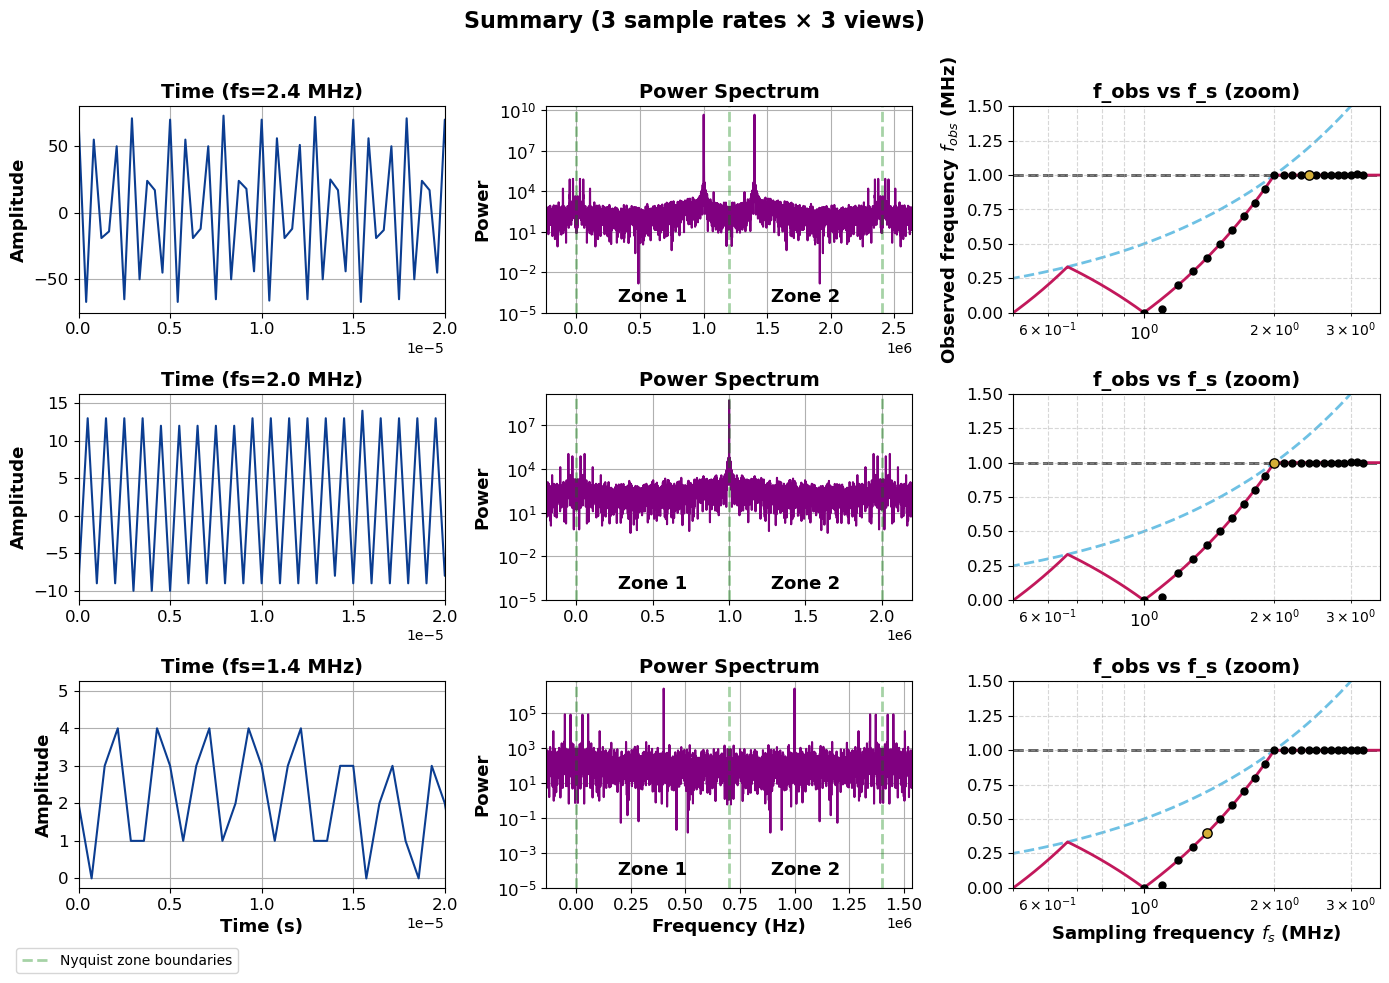

In [138]:
# F1
# Signal + Power Spectrum + (Zoomed) f_obs vs f_s  (Hann)

import os
import re
import numpy as np
import matplotlib.pyplot as plt
import wesleyanalysis

# -------------------
# Paths
# -------------------
DATA_DIR = r"C:\Users\Storm\Astron 121\Data\F1_1MHz_2mV\data"
PLOTS_DIR = os.path.join(DATA_DIR, "analysis_plots")
os.makedirs(PLOTS_DIR, exist_ok=True)

# -------------------
# Helpers
# -------------------
def load_capture(fp):
    obj = np.load(fp)
    if isinstance(obj, np.lib.npyio.NpzFile):
        return obj[obj.files[0]]
    return obj

def parse_fs(fname):
    m = re.search(r"digital_sin_([0-9]+(?:\.[0-9]+)?)", fname)
    return float(m.group(1)) if m else None

# -------------------
# Find data files
# -------------------
files = []
for fn in os.listdir(DATA_DIR):
    if fn.startswith("digital_sin_") and fn.endswith(".npz"):
        fs = parse_fs(fn)
        if fs is not None:
            files.append((fs, os.path.join(DATA_DIR, fn)))

files.sort(key=lambda x: x[0])

# -------------------
# Theory params
# -------------------
f0_mhz = 1.0
fs_min = 0.01
fs_max = 5.0
npts   = 1000

fs_theory = wesleyanalysis.logspace_fs(fs_max, fs_min, npts)
fs_theory, fobs_theory = wesleyanalysis.theory_fobs_vs_fs(f0_mhz, fs_theory)

# -------------------
# First pass: compute spectra
# -------------------
stored = []
peak_list = []

for fs, fp in files:
    data = load_capture(fp)

    x = data[1] if data.ndim == 2 else data
    ns = len(x)
    t = np.arange(ns) / fs

    x0 = x - np.mean(x)
    w  = np.hanning(ns)
    xw = x0 * w

    V = np.fft.fft(xw)
    P = np.abs(V) ** 2
    freq = np.fft.fftfreq(ns, d=1/fs)

    mask = (freq >= 0) & (freq <= fs/2)
    idx = np.argmax(P[mask])
    peak_list.append([fs, freq[mask][idx], P[mask][idx]])

    stored.append(dict(fs=fs, t=t, x=x, freq=freq, P=P))

# -------------------
# Save peaks
# -------------------
peaks = np.array(peak_list)
np.save(os.path.join(DATA_DIR, "peak_coords.npy"), peaks)

fs_meas_hz    = peaks[:, 0]
fobs_meas_hz  = peaks[:, 1]
fs_meas_mhz   = fs_meas_hz / 1e6
fobs_meas_mhz = fobs_meas_hz / 1e6

# -------------------
# Styling
# -------------------
label_fs = 13
title_fs = 14

time_color     = "#0B3D91"
power_color    = "purple"
envelope_color = "#6EC1E4"
zigzag_color   = "#C2185B"
true_color     = "#555555"
gold           = "#D4AF37"

nyq_line_color = "green"
nyq_line_style = "--"
nyq_line_width = 2
nyq_line_alpha = 0.35

# -------------------
# 9-panel figure for 2.4, 2.0, 1.4 MHz
# -------------------
TARGET_FS_MHZ = [2.4, 2.0, 1.4]
TARGET_FS_HZ  = [v * 1e6 for v in TARGET_FS_MHZ]

rows = []
for target in TARGET_FS_HZ:
    rows.append(min(stored, key=lambda d: abs(d["fs"] - target)))

fig9, axes = plt.subplots(3, 3, figsize=(14, 10))
fig9.suptitle("Summary (3 sample rates × 3 views)",
              fontsize=title_fs + 2, fontweight="bold")

for r, item in enumerate(rows):
    fs = item["fs"]
    t  = item["t"]
    x  = item["x"]
    freq = item["freq"]
    P    = item["P"]

    order = np.argsort(freq)
    f_sorted = freq[order]
    P_sorted = P[order]
    f_ext = np.concatenate([f_sorted, f_sorted + fs])
    P_ext = np.concatenate([P_sorted, P_sorted])

    i_current = int(np.argmin(np.abs(fs_meas_hz - fs)))

    # ---- time ----
    ax = axes[r, 0]
    ax.plot(t, x, color=time_color)
    ax.set_xlim(0, 2e-5)
    ax.set_title(f"Time (fs={fs/1e6:.1f} MHz)",
                 fontsize=title_fs, fontweight="bold")
    ax.set_ylabel("Amplitude", fontsize=label_fs, fontweight="bold")
    ax.grid(True)

    # ---- power spectrum ----
    ax = axes[r, 1]
    ax.plot(f_ext, P_ext, color=power_color)
    ax.set_yscale("log")
    ax.set_ylim(bottom=1e-5)
    ax.set_xlim(-0.1 * fs, 1.1 * fs)

    for j, xv in enumerate([0, fs/2, fs]):
        ax.axvline(
            xv,
            color=nyq_line_color,
            linestyle=nyq_line_style,
            linewidth=nyq_line_width,
            alpha=nyq_line_alpha,
            label="Nyquist zone boundaries" if (r == 0 and j == 0) else None
        )

    y_min = ax.get_ylim()[0]
    y_text = y_min * 3.0

    ax.text(fs/4,   y_text, "Zone 1",
            ha="center", va="bottom",
            fontsize=label_fs, fontweight="bold")
    ax.text(3*fs/4, y_text, "Zone 2",
            ha="center", va="bottom",
            fontsize=label_fs, fontweight="bold")

    ax.set_title("Power Spectrum",
                 fontsize=title_fs, fontweight="bold")
    ax.set_ylabel("Power",
                  fontsize=label_fs, fontweight="bold")
    ax.grid(True)

    # ---- f_obs vs f_s ----
    ax = axes[r, 2]
    ax.plot(fs_theory, fobs_theory,
            color=zigzag_color, linewidth=2, zorder=2)
    ax.plot(fs_theory, fs_theory/2,
            "--", color=envelope_color, linewidth=2, zorder=1)
    ax.axhline(f0_mhz,
               linestyle="--", color=true_color, linewidth=2, zorder=1)

    ax.scatter(fs_meas_mhz, fobs_meas_mhz,
               s=25, color="black", edgecolor="black", zorder=5)
    ax.scatter(fs_meas_mhz[i_current], fobs_meas_mhz[i_current],
               s=45, color=gold, edgecolor="black", zorder=6)

    ax.set_xlim(0.5, 3.5)
    ax.set_ylim(0, 1.5)
    ax.set_xscale("log")
    ax.set_title("f_obs vs f_s (zoom)",
                 fontsize=title_fs, fontweight="bold")
    ax.grid(True, which="both", ls="--", alpha=0.5)

    for c in range(3):
        axes[r, c].tick_params(labelsize=label_fs-1)

axes[2, 0].set_xlabel("Time (s)", fontsize=label_fs, fontweight="bold")
axes[2, 1].set_xlabel("Frequency (Hz)", fontsize=label_fs, fontweight="bold")
axes[2, 2].set_xlabel("Sampling frequency $f_s$ (MHz)",
                       fontsize=label_fs, fontweight="bold")
axes[0, 2].set_ylabel("Observed frequency $f_{obs}$ (MHz)",
                       fontsize=label_fs, fontweight="bold")

fig9.legend(loc="lower left", bbox_to_anchor=(0.01, 0.01))
fig9.tight_layout(rect=[0, 0.03, 1, 0.96])

out9 = os.path.join(PLOTS_DIR, "summary_9panel_fs_2p4_2p0_1p4MHz.png")
fig9.savefig(out9, bbox_inches="tight")
plt.show()


Figure 1: This figure shows the time-domain signal, the corresponding power spectrum, and the observed frequency $f_{\mathrm{obs}}$ as a function of sampling frequency $f_s$ for a 1.0MHz input signal, using experimental data extracted from recorded voltage time series. The three rows correspond to sampling frequencies of 2.4MHz, 2.0MHz, and 1.4MHz, chosen to illustrate the progression of aliasing as the sampling rate decreases. In the power spectrum panels, the green dashed vertical lines mark the boundaries between Nyquist zones, highlighting how spectral power folds into lower frequencies when undersampling occurs. In the $f_{\mathrm{obs}}$ vs. $f_s$ plots, the black points show experimentally measured peak frequencies, while the highlighted gold point indicates the specific sampling rate corresponding to the time and power spectra shown in the same row. As aliasing becomes significant, the observed frequency deviates from the true signal frequency and the apparent oscillation rate in the time-domain signal changes, demonstrating the consequences of sampling below the Nyquist criterion.


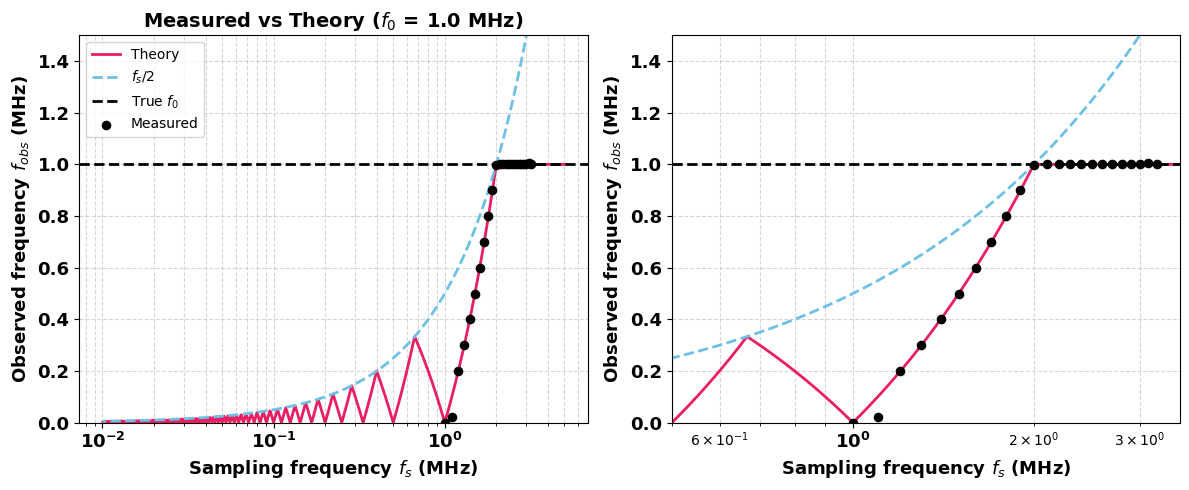

In [137]:
# F1
# Compute peak_coords.npy from digital_sin_*.npz (Hann + DC removal),
# then plot measured f_obs vs f_s over theory.

import os
import re
import numpy as np
import matplotlib.pyplot as plt
import wesleyanalysis   # <-- your library

# -------------------
# Paths
# -------------------
DATA_DIR = r"C:\Users\Storm\Astron 121\Data\F1_1MHz_2mV\data"
PLOTS_DIR = os.path.join(DATA_DIR, "analysis_plots")
os.makedirs(PLOTS_DIR, exist_ok=True)

PEAKS_NPY = os.path.join(DATA_DIR, "peak_coords.npy")
PEAKS_CSV = os.path.join(DATA_DIR, "peak_coords.csv")

# -------------------
# Helpers (from your peak-finding script)
# -------------------
def load_capture(fp):
    obj = np.load(fp)
    if isinstance(obj, np.lib.npyio.NpzFile):
        return obj[obj.files[0]]
    return obj

def parse_fs(fname):
    m = re.search(r"digital_sin_([0-9]+(?:\.[0-9]+)?)", fname)
    return float(m.group(1)) if m else None

def find_files(data_dir):
    files = []
    for fn in os.listdir(data_dir):
        if fn.startswith("digital_sin_") and fn.endswith(".npz"):
            fs = parse_fs(fn)
            if fs is not None:
                files.append((fs, os.path.join(data_dir, fn)))
    files.sort(key=lambda x: x[0])
    return files

def compute_peak_coords(files, save_npy=PEAKS_NPY, save_csv=PEAKS_CSV,
                        use_hann=True, remove_dc=True):
    """
    For each file, compute FFT power spectrum and pick the single highest peak
    in the first Nyquist zone [0, fs/2]. Save peaks as:
      [fs_hz, f_peak_hz, power_peak]
    """
    peak_list = []

    for fs, fp in files:
        data = load_capture(fp)

        # choose one block
        if data.ndim == 2:
            x = data[1] if data.shape[0] > 1 else data[0]
        else:
            x = data

        ns = len(x)

        # preprocessing
        if remove_dc:
            x = x - np.mean(x)

        if use_hann:
            w = np.hanning(ns)
        else:
            w = np.ones(ns)

        X = np.fft.fftshift(np.fft.fft(x * w))
        freq = np.fft.fftshift(np.fft.fftfreq(ns, d=1/fs))
        power = np.abs(X) ** 2

        # first Nyquist zone: 0 to fs/2
        mask = (freq >= 0) & (freq <= fs/2)
        power_nyq = power[mask]
        freq_nyq  = freq[mask]

        idx_local = np.argmax(power_nyq)
        f_peak = float(freq_nyq[idx_local])
        p_peak = float(power_nyq[idx_local])

        peak_list.append([float(fs), f_peak, p_peak])

    peaks = np.array(peak_list, dtype=float)

    np.save(save_npy, peaks)
    np.savetxt(
        save_csv,
        peaks,
        delimiter=",",
        header="fs_hz,f_peak_hz,power_peak",
        comments=""
    )

    return peaks

# -------------------
# Build peaks
# -------------------
files = find_files(DATA_DIR)
if len(files) == 0:
    raise FileNotFoundError("No digital_sin_*.npz files found in DATA_DIR")

peaks = compute_peak_coords(
    files,
    save_npy=PEAKS_NPY,
    save_csv=PEAKS_CSV,
    use_hann=True,
    remove_dc=True
)

# -------------------
# Load measured results
# -------------------
fs_meas_hz   = peaks[:, 0]
fobs_meas_hz = peaks[:, 1]

fs_meas_mhz   = fs_meas_hz / 1e6
fobs_meas_mhz = fobs_meas_hz / 1e6

# -------------------
# THEORY PARAMETERS
# -------------------
f0_mhz = 1.0
fs_min = 0.01
fs_max = 5.0
npts   = 1000

# -------------------
# Theory curve
# -------------------
fs_theory = wesleyanalysis.logspace_fs(fs_max, fs_min, npts)
fs_theory, fobs_theory = wesleyanalysis.theory_fobs_vs_fs(f0_mhz, fs_theory)

# -------------------
# Plot: full + zoomed
# -------------------
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

pink = "#E91E63"
light_blue = "#6EC1E4"
black = "black"

# ---- LEFT: full range ----
ax1.plot(fs_theory, fobs_theory, color=pink, linewidth=2, label="Theory")
ax1.plot(fs_theory, fs_theory / 2, "--", color=light_blue, linewidth=2, label=r"$f_s/2$")
ax1.axhline(f0_mhz, linestyle="--", color=black, linewidth=2, label=r"True $f_0$")
ax1.scatter(fs_meas_mhz, fobs_meas_mhz, s=35, color=black, label="Measured", zorder=5)

ax1.set_ylim(0, 1.5)
ax1.set_xscale("log")
ax1.set_xlabel("Sampling frequency $f_s$ (MHz)", fontsize=13, fontweight="bold")
ax1.set_ylabel("Observed frequency $f_{obs}$ (MHz)", fontsize=13, fontweight="bold")
ax1.set_title(f"Measured vs Theory ($f_0$ = {f0_mhz} MHz)", fontsize=14, fontweight="bold")
ax1.grid(True, which="both", ls="--", alpha=0.5)
ax1.legend()

# ---- RIGHT: zoomed ----
ax2.plot(fs_theory, fobs_theory, color=pink, linewidth=2)
ax2.plot(fs_theory, fs_theory / 2, "--", color=light_blue, linewidth=2)
ax2.axhline(f0_mhz, linestyle="--", color=black, linewidth=2)
ax2.scatter(fs_meas_mhz, fobs_meas_mhz, s=35, color=black, zorder=5)

ax2.set_ylim(0, 1.5)
ax2.set_xlim(0.5, 3.5)
ax2.set_xscale("log")
ax2.set_xlabel("Sampling frequency $f_s$ (MHz)", fontsize=13, fontweight="bold")
ax2.set_ylabel("Observed frequency $f_{obs}$ (MHz)", fontsize=13, fontweight="bold")
ax2.grid(True, which="both", ls="--", alpha=0.5)

# bold ticks
for ax in (ax1, ax2):
    ax.tick_params(axis="both", labelsize=13)
    for tick in ax.get_xticklabels() + ax.get_yticklabels():
        tick.set_fontweight("bold")

fig.tight_layout()
fig.savefig(
    os.path.join(PLOTS_DIR, "fobs_vs_fs_overlay_full_and_zoom_side_by_side.png"),
    bbox_inches="tight"
)

plt.show()


Figure 2: These plots show the observed frequency $f_{\mathrm{obs}}$ of the dominant power-spectrum peak as a function of sampling frequency $f_s$ for a 1.0MHz input signal, comparing experimental measurements to the theoretical aliasing prediction. The black points are experimental values extracted by selecting the single highest peak in each measured power spectrum, computed from 4096-sample voltage time series after DC offset removal and Hann windowing; the pink zig-zag curve shows the theoretically accepted observed frequency, the blue dashed curve marks the Nyquist frequency $f_s/2$, and the horizontal dashed line indicates the true signal frequency. The full-range plot reveals the characteristic aliasing structure and collapse of the observed frequency toward DC at low sampling rates, while the zoomed panel highlights deviations from the true frequency when the Nyquist criterion is violated, demonstrating how undersampling leads to incorrect frequency identification.

Shown in Figure 1 (Above), we measured the amplitude of a generated 1.0~MHz sine wave at sampling frequencies of 2.4~MHz, 2.0~MHz, and 1.4~MHz in order to observe aliasing effects. For each sampling frequency, 4096 samples were recorded from the voltage time series. After gathering this data, the power spectrum was computed for each sampling frequency to determine the observed frequency present in the sampled signal. The observed frequency was extracted by selecting the frequency corresponding to the largest peak in the power spectrum, ensuring that the dominant spectral component was used for comparison. These results, in the format $(f_{\mathrm{obs}}, f_s)$, were plotted against the theoretically accepted observed frequency as a function of sampling frequency, given by
\begin{equation}
f_{\mathrm{obs}} = \left| \left( (f_0 + f_s/2) \bmod f_s \right) - f_s/2 \right|.
\end{equation}

During analysis, a Hann window was applied prior to computing the Fourier transform. This window reduces spectral leakage compared to a top-hat (rectangular) window by smoothly tapering the signal to zero at the edges of the observation window. Additionally, the DC offset was removed from each time-domain signal before windowing. This suppresses the zero-frequency component and prevents contamination of low-frequency spectral peaks.

For the 2.4~MHz sampling frequency case, no aliasing is observed because the sampling frequency is greater than twice the signal frequency, satisfying the Nyquist criterion. In the corresponding power spectrum, the true 1.0~MHz frequency lies entirely within the first Nyquist zone, confirming the absence of aliasing. This behavior is also reflected in the $f_{\mathrm{obs}}$ versus $f_s$ plot, where the highlighted gold point lies at an observed frequency of 1.0~MHz, in agreement with theory.

When the sampling frequency is reduced to 2.0~MHz, the system is exactly at the Nyquist limit and therefore at the boundary of aliasing. In the time-domain plot, the signal appears as a two-point oscillation, indicating that the waveform is sampled only twice per cycle. The upper and lower amplitudes are not always exactly equal. This asymmetry is most likely due to a small mismatch between the nominal sampling frequency and its true value, such that $f_s$ does not exactly equal $2f_0$. The power spectrum shows a strong spike at the Nyquist frequency, and in the $f_{\mathrm{obs}}$ versus $f_s$ plot the gold point lies at the turning point of the theoretical curve.

When the sampling frequency is further reduced toward 1.4~MHz, aliasing becomes significant. Although experimental limitations prevented sampling below 1.0~MHz, the measured data up to this point generally follow the predicted pink zig-zag aliasing curve; thus, we hypothesize that if given the opportunity to sample at lower sampling rate, that those new data points will continue to follow the pink zig-zag line (See Figure 2 Above). One measured point deviates slightly from the theoretical prediction. This deviation corresponds to a sampling frequency near 1.1~MHz, where multiple power-spectrum spikes appear evenly spaced around 0~Hz. At this sampling rate, the observed aliased frequency is very low ($f_{\mathrm{obs}} \approx 0.1$~MHz), corresponding to a beat period of approximately 10~$\mu$s. With a sampling rate of 1.1~MHz and 4096 samples, the total acquisition time is only about 3.7~$\mu$s, meaning that less than one full oscillation of the aliased signal is captured. As a result, the FFT truncates the waveform, introducing discontinuities that spread energy across nearby frequency bins and produce multiple low-frequency peaks.

The central conclusion of this analysis is that the measured frequency alone cannot be trusted when aliasing is present. Without knowing which Nyquist zone the true signal frequency occupies, the observed frequency may correspond to multiple possible true frequencies. Correct recovery of the signal therefore requires identifying the appropriate Nyquist zone and applying the aliasing relation above. This demonstrates that sampling below the Nyquist criterion leads to ambiguous frequency identification unless prior knowledge of the signal band is available.


In [178]:
# F3
# Experimental vs Accepted (simulated) POWER SPECTRUM
# THREE SUBPLOTS:
#   1) Experimental
#   2) Accepted (simulated)
#   3) Overlay (both)
# RECTANGULAR window, saved directly in:
# C:\Users\Storm\Astron 121\Data\F3_1MHz_5mV\data

import os
import re
import numpy as np
import matplotlib.pyplot as plt
import wesleyanalysis

# -------------------
# Paths
# -------------------
DATA_DIR = r"C:\Users\Storm\Astron 121\Data\F3_1MHz_5mV\data"
PLOTS_DIR = DATA_DIR  # SAVE HERE

# -------------------
# Helpers
# -------------------
def load_capture(fp):
    obj = np.load(fp, allow_pickle=True)
    if isinstance(obj, np.lib.npyio.NpzFile):
        for k in ("the_data", "data", "x"):
            if k in obj.files:
                return obj[k]
        return obj[obj.files[0]]
    return obj

def parse_ns(fname):
    m = re.search(r"ns[_\-]?(\d+)", fname)
    return int(m.group(1)) if m else None

def set_log_ylim_from_data(ax, y, ymask=None,
                           floor_pct=1, headroom=1.2,
                           dyn_range_decades=10):
    yy = y[ymask] if ymask is not None else y
    yy = np.asarray(yy)
    yy = yy[np.isfinite(yy) & (yy > 0)]
    if yy.size == 0:
        return

    peak = np.max(yy)
    floor = np.percentile(yy, floor_pct)
    ymin_from_peak = peak / (10**dyn_range_decades)
    ymin = max(min(floor, ymin_from_peak), peak * 1e-20)
    ymax = peak * headroom
    ax.set_ylim(ymin, ymax)

# -------------------
# Find data files
# -------------------
files = []
for fn in os.listdir(DATA_DIR):
    if fn.endswith(".npz") or fn.endswith(".npy"):
        ns = parse_ns(fn)
        files.append((ns, os.path.join(DATA_DIR, fn), fn))

files.sort(key=lambda x: (x[0] is None,
                          x[0] if x[0] is not None else 0,
                          x[2]))

# -------------------
# Constants
# -------------------
fs = 3e6
fmin = 0.8e6
fmax = 1.2e6
F0_HZ = 1.0e6

peak_list = []

# -------------------
# Main loop
# -------------------
for ns_guess, fp, fn in files:
    data = load_capture(fp)

    # always use block 1
    x = data[1] if isinstance(data, np.ndarray) and data.ndim == 2 else np.asarray(data)
    ns = len(x)

    # -------------------
    # Experimental (RECT)
    # -------------------
    xw = x - np.mean(x)
    P_exp = wesleyanalysis.power_spectrum(xw)
    freq = np.fft.fftfreq(ns, d=1/fs)

    P_exp = np.fft.fftshift(P_exp)
    freq  = np.fft.fftshift(freq)

    # peak (positive freqs)
    mask_pos = (freq >= 0) & (freq <= fs/2)
    idx = np.argmax(P_exp[mask_pos])
    f_peak = float(freq[mask_pos][idx])
    p_peak = float(P_exp[mask_pos][idx])
    peak_list.append([ns, ns/fs, fs, f_peak, p_peak])

    # -------------------
    # Accepted (simulated, RECT)
    # -------------------
    t_sim = np.arange(ns) / fs
    x_sim = np.sin(2 * np.pi * F0_HZ * t_sim)
    x_sim -= np.mean(x_sim)

    P_acc = wesleyanalysis.power_spectrum(x_sim)
    P_acc = np.fft.fftshift(P_acc)

    # -------------------
    # Normalize separately
    # -------------------
    P_exp_n = P_exp / np.max(P_exp)
    P_acc_n = P_acc / np.max(P_acc)

    zoom = (freq >= fmin) & (freq <= fmax)

    # -------------------
    # THREE-SUBPLOT FIGURE (ZOOMED)
    # -------------------
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(9, 9), sharex=True)

    # Experimental
    ax1.plot(freq[zoom], P_exp_n[zoom], color="red", lw=2)
    ax1.set_yscale("log")
    set_log_ylim_from_data(ax1, P_exp_n, zoom)
    ax1.set_ylabel("Norm. Power")
    ax1.set_title(f"Experimental (RECT), ns={ns}")
    ax1.grid(True, which="both", alpha=0.5)

    # Accepted
    ax2.plot(freq[zoom], P_acc_n[zoom], color="black", lw=2, ls="--")
    ax2.set_yscale("log")
    set_log_ylim_from_data(ax2, P_acc_n, zoom)
    ax2.set_ylabel("Norm. Power")
    ax2.set_title("Accepted / Simulated (RECT)")
    ax2.grid(True, which="both", alpha=0.5)

    # Overlay
    ax3.plot(freq[zoom], P_exp_n[zoom], color="red", lw=2, label="Experimental")
    ax3.plot(freq[zoom], P_acc_n[zoom], color="black", lw=2, ls="--",
             label="Accepted")
    ax3.set_yscale("log")
    set_log_ylim_from_data(ax3, P_exp_n, zoom)
    ax3.set_xlabel("Frequency (Hz)")
    ax3.set_ylabel("Norm. Power")
    ax3.set_title("Overlay (Experimental vs Accepted)")
    ax3.grid(True, which="both", alpha=0.5)
    ax3.legend(fontsize=9)

    ax3.set_xlim(fmin, fmax)

    fig.tight_layout()
    fig.savefig(
        os.path.join(PLOTS_DIR, f"F3_power_3subplots_exp_acc_overlay_rect_ns_{ns}.png"),
        bbox_inches="tight"
    )
    plt.close(fig)

    print(f"Saved 3-subplot spectra for ns = {ns}")

# -------------------
# Save peak summary
# -------------------
peaks = np.array(peak_list, dtype=float)
np.save(os.path.join(PLOTS_DIR, "F3_peak_coords_ns_sweep_rect.npy"), peaks)
np.savetxt(
    os.path.join(PLOTS_DIR, "F3_peak_coords_ns_sweep_rect.csv"),
    peaks,
    delimiter=",",
    header="ns,T_sec,fs_hz,f_peak_hz,power_peak",
    comments=""
)

print("Done.")


Saved 3-subplot spectra for ns = 1024
Saved 3-subplot spectra for ns = 2048
Saved 3-subplot spectra for ns = 3072
Saved 3-subplot spectra for ns = 4096
Saved 3-subplot spectra for ns = 5
Saved 3-subplot spectra for ns = 5
Done.


In [177]:
#F3
#Signal, Voltage Spectrum, Power Spectrum (RECTANGULAR window, improved log scaling)
# + EXTRA plots: accepted (theory f0) vs experimental (measured peak) overlays

import os
import re
import numpy as np
import matplotlib.pyplot as plt
import wesleyanalysis

# -------------------
# Paths
# -------------------
DATA_DIR  = r"C:\Users\Storm\Astron 121\Data\F3_1MHz_5mV\data"
PLOTS_DIR = DATA_DIR  # SAVE DIRECTLY IN DATA_DIR
print("PLOTS_DIR =", PLOTS_DIR)


# -------------------
# Helpers
# -------------------
def load_capture(fp):
    obj = np.load(fp, allow_pickle=True)
    if isinstance(obj, np.lib.npyio.NpzFile):
        for k in ("the_data", "data", "x"):
            if k in obj.files:
                return obj[k]
        return obj[obj.files[0]]
    return obj

def parse_ns(fname):
    m = re.search(r"ns[_\-]?(\d+)", fname)
    return int(m.group(1)) if m else None

def set_log_ylim_from_data(ax, y, ymask=None,
                           floor_pct=1, headroom=1.2,
                           dyn_range_decades=10):
    """
    Log y-limits that avoid both white space and clipping.

    ymax = headroom * peak
    ymin = max( percentile(floor_pct),
                peak / 10**dyn_range_decades )
    """
    yy = y[ymask] if ymask is not None else y
    yy = np.asarray(yy)
    yy = yy[np.isfinite(yy) & (yy > 0)]
    if yy.size == 0:
        return

    peak = np.max(yy)
    floor = np.percentile(yy, floor_pct)

    ymin_from_peak = peak / (10**dyn_range_decades)
    ymin = max(min(floor, ymin_from_peak), peak * 1e-20)
    ymax = peak * headroom

    ax.set_ylim(ymin, ymax)

# -------------------
# Find data files
# -------------------
files = []
for fn in os.listdir(DATA_DIR):
    if fn.endswith(".npz") or fn.endswith(".npy"):
        ns = parse_ns(fn)
        files.append((ns, os.path.join(DATA_DIR, fn), fn))

files.sort(key=lambda x: (x[0] is None,
                          x[0] if x[0] is not None else 0,
                          x[2]))

# -------------------
# Constants
# -------------------
fs = 3e6
fmin = 0.8e6
fmax = 1.2e6

# accepted (theory) frequency for this dataset
F0_HZ = 1.0e6

# styling for accepted vs experimental markers
accepted_color = "black"
exp_color = "red"
accepted_ls = "--"
exp_ls = "-"

peak_list = []

# -------------------
# Main loop
# -------------------
for ns_guess, fp, fn in files:
    print("Processing file:", fn)
    data = load_capture(fp)

    # always use block 1
    x = data[1] if isinstance(data, np.ndarray) and data.ndim == 2 else np.asarray(data)

    ns = len(x)
    T = ns / fs
    t = np.arange(ns) / fs

    # -------------------
    # Preprocessing (RECTANGULAR window)
    # -------------------
    x0 = x - np.mean(x)
    xw = x0

    # -------------------
    # Spectra
    # -------------------
    V = wesleyanalysis.voltage_spectrum(xw)
    P = wesleyanalysis.power_spectrum(xw)
    freq = np.fft.fftfreq(ns, d=1/fs)

    V = np.fft.fftshift(V)
    P = np.fft.fftshift(P)
    freq = np.fft.fftshift(freq)
    Vmag = np.abs(V)

    # -------------------
    # Peak finding (experimental)
    # -------------------
    mask = (freq >= 0) & (freq <= fs/2)
    idx = np.argmax(P[mask])
    f_peak = float(freq[mask][idx])
    p_peak = float(P[mask][idx])
    peak_list.append([ns, T, fs, f_peak, p_peak])

    # ============================================================
    # FIGURE 1 — FULL SPECTRUM
    # ============================================================
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(7, 9))

    ax1.plot(t, x)
    ax1.set_xlim(0, min(2e-5, t[-1]))
    ax1.set_ylabel("Amplitude")
    ax1.set_title(f"Signal / Voltage / Power (RECT, fs={fs:.1f} Hz, ns={ns})")
    ax1.grid(True)

    ax2.plot(freq, Vmag)
    ax2.axvline(0, ls="--")
    ax2.axvline(fs/2, ls="--")
    ax2.axvline(-fs/2, ls="--")
    ax2.set_ylabel("|FFT|")
    ax2.grid(True)

    ax3.plot(freq, P)
    ax3.set_yscale("log")
    set_log_ylim_from_data(ax3, P)
    ax3.axvline(0, ls="--")
    ax3.axvline(fs/2, ls="--")
    ax3.axvline(-fs/2, ls="--")
    ax3.set_xlabel("Frequency (Hz)")
    ax3.set_ylabel("Power")
    ax3.grid(True)

    fig.tight_layout()
    fig.savefig(
        os.path.join(PLOTS_DIR, f"signal_voltage_power_ns_{ns}_rect.png"),
        bbox_inches="tight"
    )
    plt.close(fig)

    # ============================================================
    # FIGURE 2 — ZOOMED 0.8–1.2 MHz
    # ============================================================
    zoom_mask = (freq >= fmin) & (freq <= fmax)

    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(7, 9))

    ax1.plot(t, x)
    ax1.set_xlim(0, min(2e-5, t[-1]))
    ax1.set_ylabel("Amplitude")
    ax1.set_title(f"Signal / Voltage / Power (RECT, zoomed, ns={ns})")
    ax1.grid(True)

    ax2.plot(freq, Vmag)
    ax2.set_xlim(fmin, fmax)
    ax2.set_ylabel("|FFT|")
    ax2.grid(True)

    ax3.plot(freq, P)
    ax3.set_xlim(fmin, fmax)
    ax3.set_yscale("log")
    set_log_ylim_from_data(ax3, P, ymask=zoom_mask)
    ax3.set_xlabel("Frequency (Hz)")
    ax3.set_ylabel("Power")
    ax3.grid(True)

    fig.tight_layout()
    fig.savefig(
        os.path.join(PLOTS_DIR, f"signal_voltage_power_ns_{ns}_rect_zoom.png"),
        bbox_inches="tight"
    )
    plt.close(fig)

    # ============================================================
    # EXTRA FIGURE A — FULL SPECTRUM w/ accepted vs experimental lines
    # ============================================================
    fig, ax = plt.subplots(figsize=(8, 4.5))
    ax.plot(freq, P)
    ax.set_yscale("log")
    set_log_ylim_from_data(ax, P)
    ax.set_xlabel("Frequency (Hz)")
    ax.set_ylabel("Power")
    ax.set_title(f"Power Spectrum (RECT) with accepted vs measured peak (ns={ns})")
    ax.grid(True)

    ax.axvline(F0_HZ, color=accepted_color, linestyle=accepted_ls, linewidth=2,
               label=rf"Accepted $f_0$ = {F0_HZ/1e6:.3f} MHz")
    ax.axvline(f_peak, color=exp_color, linestyle=exp_ls, linewidth=2,
               label=rf"Measured peak $f_{{\mathrm{{peak}}}}$ = {f_peak/1e6:.3f} MHz")

    ax.legend()
    fig.tight_layout()
    fig.savefig(
        os.path.join(PLOTS_DIR, f"power_with_accepted_vs_measured_ns_{ns}_full.png"),
        bbox_inches="tight"
    )
    plt.close(fig)

    # ============================================================
    # EXTRA FIGURE B — ZOOMED 0.8–1.2 MHz w/ accepted vs experimental lines
    # ============================================================
    fig, ax = plt.subplots(figsize=(8, 4.5))
    ax.plot(freq, P)
    ax.set_xlim(fmin, fmax)
    ax.set_yscale("log")
    set_log_ylim_from_data(ax, P, ymask=zoom_mask)
    ax.set_xlabel("Frequency (Hz)")
    ax.set_ylabel("Power")
    ax.set_title(f"Power Spectrum (RECT, zoom) with accepted vs measured peak (ns={ns})")
    ax.grid(True)

    ax.axvline(F0_HZ, color=accepted_color, linestyle=accepted_ls, linewidth=2,
               label=rf"Accepted $f_0$ = {F0_HZ/1e6:.3f} MHz")
    ax.axvline(f_peak, color=exp_color, linestyle=exp_ls, linewidth=2,
               label=rf"Measured peak $f_{{\mathrm{{peak}}}}$ = {f_peak/1e6:.3f} MHz")

    ax.legend()
    fig.tight_layout()
    fig.savefig(
        os.path.join(PLOTS_DIR, f"power_with_accepted_vs_measured_ns_{ns}_zoom.png"),
        bbox_inches="tight"
    )
    plt.close(fig)

    print(f"Saved plots for ns = {ns}")

# -------------------
# Save peak summary
# -------------------
peaks = np.array(peak_list, dtype=float)
np.save(os.path.join(PLOTS_DIR, "peak_coords_ns_sweep_rect.npy"), peaks)
np.savetxt(
    os.path.join(PLOTS_DIR, "peak_coords_ns_sweep_rect.csv"),
    peaks,
    delimiter=",",
    header="ns,T_sec,fs_hz,f_peak_hz,power_peak",
    comments=""
)

# -------------------
# SUMMARY PLOT — f_peak vs ns with accepted f0 line
# -------------------
ns_arr = peaks[:, 0]
fpeak_arr = peaks[:, 3]

fig, ax = plt.subplots(figsize=(7.5, 4.5))
ax.scatter(ns_arr, fpeak_arr, color=exp_color, s=45, label=r"Measured $f_{\mathrm{peak}}$")
ax.axhline(F0_HZ, color=accepted_color, linestyle=accepted_ls, linewidth=2,
           label=rf"Accepted $f_0$ = {F0_HZ/1e6:.3f} MHz")

ax.set_xlabel("Number of samples $n_s$")
ax.set_ylabel("Frequency (Hz)")
ax.set_title("Measured peak frequency vs sample count (RECT window)")
ax.grid(True)
ax.legend()

fig.tight_layout()

fig.savefig(os.path.join(PLOTS_DIR, "fpeak_vs_ns_rect_accepted_vs_measured.png"),
            bbox_inches="tight")
plt.close(fig)

print("Done.")


PLOTS_DIR = C:\Users\Storm\Astron 121\Data\F3_1MHz_5mV\data
Processing file: digital_sin_ns_1024.npz
Saved plots for ns = 1024
Processing file: digital_sin_ns_2048.npz
Saved plots for ns = 2048
Processing file: digital_sin_ns_3072.npz
Saved plots for ns = 3072
Processing file: digital_sin_ns_4096.npz
Saved plots for ns = 4096
Processing file: F3_peak_coords_ns_sweep_rect.npy
Saved plots for ns = 5
Processing file: peak_coords_ns_sweep_rect.npy
Saved plots for ns = 5
Done.


In [60]:
#Results or Discussion:

import sys, os
print(sys.executable)   # which Python is running this code
print(os.getcwd())      # where the code is running from


C:\Users\Storm\anaconda3\python.exe
C:\Users\Storm\Astron 121


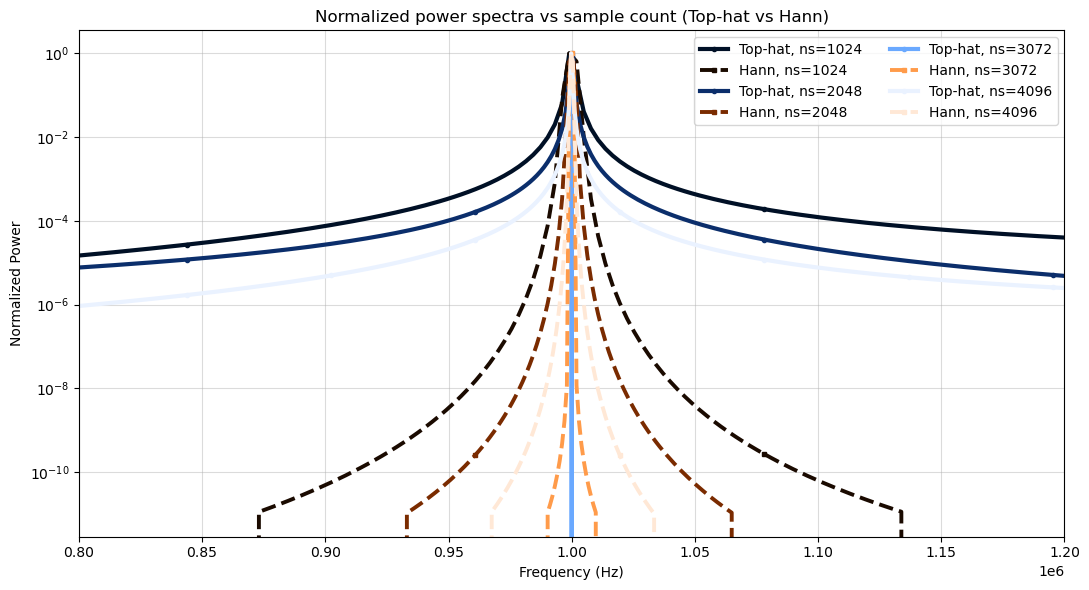

In [155]:
# Simulated-only: TOP-HAT vs HANN
# Sweep over ns = [1024, 2048, 3072, 4096]
# Extreme dark→light ramps (manual hex colors)

import numpy as np
import matplotlib.pyplot as plt

# -------------------
# Simulation params
# -------------------
fs = 3.0e6
f0 = 1.0e6
amp = 1.0

ns_list = [1024, 2048, 3072, 4096]
POWER_FLOOR = 1e-11

# -------------------
# Plot setup
# -------------------
fig, ax = plt.subplots(figsize=(11, 6))

# EXTREME ramps: darkest -> lightest
colors_rect = ["#001026", "#0B2E6B", "#6AA9FF", "#EAF2FF"]   # navy -> near-white blue
colors_hann = ["#1A0A00", "#7A2B00", "#FF9B4A", "#FFE8D6"]   # near-black orange -> near-white peach

# -------------------
# Loop over ns
# -------------------
for i, ns in enumerate(ns_list):

    t = np.arange(ns) / fs
    x = amp * np.sin(2*np.pi*f0*t)
    x0 = x - np.mean(x)

    w_rect = np.ones(ns)
    w_hann = np.hanning(ns)

    x_rect = x0 * w_rect
    x_hann = x0 * w_hann

    freq = np.fft.fftfreq(ns, d=1/fs)

    X_rect = np.fft.fft(x_rect)
    X_hann = np.fft.fft(x_hann)

    P_rect = np.abs(X_rect)**2
    P_hann = np.abs(X_hann)**2

    # normalize each by its own peak
    P_rect /= np.max(P_rect)
    P_hann /= np.max(P_hann)

    # apply floor
    P_rect[P_rect < POWER_FLOOR] = 0.0
    P_hann[P_hann < POWER_FLOOR] = 0.0

    # shift for plotting
    freq_s   = np.fft.fftshift(freq)
    P_rect_s = np.fft.fftshift(P_rect)
    P_hann_s = np.fft.fftshift(P_hann)

    # plot
    ax.plot(
        freq_s, P_rect_s,
        linewidth=3.0,
        color=colors_rect[i],
        marker="o", markevery=80, markersize=3,
        label=f"Top-hat, ns={ns}"
    )

    ax.plot(
        freq_s, P_hann_s,
        linewidth=2.8,
        linestyle="--",
        color=colors_hann[i],
        marker="s", markevery=80, markersize=3,
        label=f"Hann, ns={ns}"
    )

# -------------------
# Axes styling
# -------------------
ax.set_yscale("log")
ax.set_xlim(0.8e6, 1.2e6)
ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel("Normalized Power")
ax.set_title("Normalized power spectra vs sample count (Top-hat vs Hann)")
ax.grid(True, which="both", alpha=0.45)
ax.legend(ncol=2, fontsize=10)

plt.tight_layout()
plt.show()


In [179]:
# F3
# Plot 4 EXPERIMENTAL power spectra on ONE plot in a clean way:
#   bin-averaged (envelope-style) spectrum vs frequency offset Δf = |f - f_peak|
# This emphasizes how leakage decreases as record time T increases, without fitting anything.
#
# Saves directly in:
# C:\Users\Storm\Astron 121\Data\F3_1MHz_5mV\data

import os
import re
import numpy as np
import matplotlib.pyplot as plt
import wesleyanalysis

# -------------------
# Paths
# -------------------
DATA_DIR = r"C:\Users\Storm\Astron 121\Data\F3_1MHz_5mV\data"
PLOTS_DIR = DATA_DIR  # SAVE HERE

# -------------------
# User knobs
# -------------------
FS_HZ = 3e6

# choose how to select your 4 experimental files:
#   "first4" = first 4 files after sorting by ns (recommended if you only have 4)
#   "largest4" = 4 largest ns (longest time) if you have many files
SELECT_MODE = "first4"

N_TO_PLOT = 4

# frequency range to consider (positive frequencies only)
F_POS_MIN = 0.0
F_POS_MAX = FS_HZ / 2

# Δf range to plot (Hz)
# If None, uses FS_HZ/2
DF_MAX = 0.6e6

# binning:
# log-spaced bins from df_min ~ 1/T to df_max
N_LOG_BINS = 250

# -------------------
# Helpers
# -------------------
def load_capture(fp):
    obj = np.load(fp, allow_pickle=True)
    if isinstance(obj, np.lib.npyio.NpzFile):
        for k in ("the_data", "data", "x"):
            if k in obj.files:
                return obj[k]
        return obj[obj.files[0]]
    return obj

def parse_ns(fname):
    m = re.search(r"ns[_\-]?(\d+)", fname)
    return int(m.group(1)) if m else None

def bin_average_logx(x, y, xbins):
    """
    xbins: array of bin edges (monotonic increasing)
    returns: x_centers, y_mean
    """
    x = np.asarray(x)
    y = np.asarray(y)

    inds = np.digitize(x, xbins) - 1
    nb = len(xbins) - 1

    x_cent = np.sqrt(xbins[:-1] * xbins[1:])  # geometric center for log bins
    y_mean = np.full(nb, np.nan, dtype=float)

    for i in range(nb):
        m = (inds == i) & np.isfinite(y) & (y > 0) & np.isfinite(x)
        if np.any(m):
            y_mean[i] = np.mean(y[m])

    return x_cent, y_mean

# -------------------
# Find data files
# -------------------
files = []
for fn in os.listdir(DATA_DIR):
    if fn.endswith(".npz") or fn.endswith(".npy"):
        ns = parse_ns(fn)
        files.append((ns, os.path.join(DATA_DIR, fn), fn))

files.sort(key=lambda x: (x[0] is None, x[0] if x[0] is not None else 0, x[2]))

if len(files) == 0:
    raise RuntimeError(f"No .npy/.npz files found in {DATA_DIR}")

# select 4 files
if SELECT_MODE == "first4":
    chosen = files[:N_TO_PLOT]
elif SELECT_MODE == "largest4":
    # keep only those with ns parsed, then take largest 4
    with_ns = [x for x in files if x[0] is not None]
    with_ns.sort(key=lambda x: x[0])
    chosen = with_ns[-N_TO_PLOT:] if len(with_ns) >= N_TO_PLOT else with_ns
else:
    raise ValueError("SELECT_MODE must be 'first4' or 'largest4'")

if len(chosen) < N_TO_PLOT:
    print(f"Warning: only found {len(chosen)} files to plot (requested {N_TO_PLOT}).")

print("Chosen files:")
for ns_guess, fp, fn in chosen:
    print("  ", fn)

# -------------------
# Build plot
# -------------------
fig, ax = plt.subplots(figsize=(9, 6.5))

for ns_guess, fp, fn in chosen:
    data = load_capture(fp)

    # always use block 1
    x = data[1] if isinstance(data, np.ndarray) and data.ndim == 2 else np.asarray(data)
    x = np.asarray(x).astype(float)
    ns = len(x)
    T = ns / FS_HZ

    # RECT preprocessing
    xw = x - np.mean(x)

    # power spectrum + frequency axis
    P = wesleyanalysis.power_spectrum(xw)
    f = np.fft.fftfreq(ns, d=1/FS_HZ)

    P = np.fft.fftshift(P)
    f = np.fft.fftshift(f)

    # keep positive freqs
    pos = (f >= F_POS_MIN) & (f <= F_POS_MAX)
    f_pos = f[pos]
    P_pos = P[pos]

    # find peak (exclude DC-ish if you want; here we just take max over pos)
    i_pk = int(np.argmax(P_pos))
    f_peak = float(f_pos[i_pk])
    P_pk = float(P_pos[i_pk])

    # normalize to its own peak (shape comparison)
    if P_pk <= 0 or not np.isfinite(P_pk):
        print(f"Skipping {fn}: non-positive/invalid peak power")
        continue
    Pn = P_pos / P_pk

    # frequency offset Δf
    df = np.abs(f_pos - f_peak)

    # restrict Δf range & drop df=0 point
    df_max = DF_MAX if DF_MAX is not None else (FS_HZ / 2)
    m = (df > 0) & (df <= df_max) & np.isfinite(Pn) & (Pn > 0)
    df = df[m]
    Pn = Pn[m]

    if df.size < 10:
        print(f"Skipping {fn}: not enough points after masking")
        continue

    # log bins: df_min ~ 1/T (fundamental resolution)
    df_min = max(1.0 / T, np.min(df[df > 0]))
    edges = np.logspace(np.log10(df_min), np.log10(df_max), N_LOG_BINS + 1)

    df_c, Pn_b = bin_average_logx(df, Pn, edges)

    # label by ns and T
    label = f"ns={ns} (T={T:.3g} s)"
    ax.plot(df_c, Pn_b, lw=2, label=label)

    print(f"{fn}: f_peak = {f_peak:.3f} Hz, T = {T:.6g} s, df_min~{df_min:.3g} Hz")

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel(r"Frequency offset  $\Delta f = |f - f_{\mathrm{peak}}|$  (Hz)")
ax.set_ylabel("Normalized Power (bin-averaged)")
ax.set_title("F3: Experimental Spectral Envelope vs Record Length (RECT)")
ax.grid(True, which="both", alpha=0.5)
ax.legend(fontsize=9)

fig.tight_layout()

out_png = os.path.join(PLOTS_DIR, "F3_exp_binavg_envelope_vs_df_4runs_rect.png")
fig.savefig(out_png, bbox_inches="tight")
plt.close(fig)

print(f"Saved: {out_png}")
print("Done.")


Chosen files:
   digital_sin_ns_1024.npz
   digital_sin_ns_2048.npz
   digital_sin_ns_3072.npz
   digital_sin_ns_4096.npz
digital_sin_ns_1024.npz: f_peak = 999023.438 Hz, T = 0.000341333 s, df_min~2.93e+03 Hz
digital_sin_ns_2048.npz: f_peak = 1001953.125 Hz, T = 0.000682667 s, df_min~1.46e+03 Hz
digital_sin_ns_3072.npz: f_peak = 1002929.687 Hz, T = 0.001024 s, df_min~977 Hz
digital_sin_ns_4096.npz: f_peak = 1002685.547 Hz, T = 0.00136533 s, df_min~732 Hz
Saved: C:\Users\Storm\Astron 121\Data\F3_1MHz_5mV\data\F3_exp_binavg_envelope_vs_df_4runs_rect.png
Done.


Chosen files:
   digital_sin_ns_1024.npz
   digital_sin_ns_2048.npz
   digital_sin_ns_3072.npz
   digital_sin_ns_4096.npz
   F3_peak_coords_ns_sweep_rect.npy
   peak_coords_ns_sweep_rect.npy
digital_sin_ns_1024.npz: ns=1024, T=0.000341333 s, peak f=999023.438 Hz
digital_sin_ns_2048.npz: ns=2048, T=0.000682667 s, peak f=1001953.125 Hz
digital_sin_ns_3072.npz: ns=3072, T=0.001024 s, peak f=1002929.687 Hz
digital_sin_ns_4096.npz: ns=4096, T=0.00136533 s, peak f=1002685.547 Hz
Skipping F3_peak_coords_ns_sweep_rect.npy: not enough positive-frequency points
Skipping peak_coords_ns_sweep_rect.npy: not enough positive-frequency points


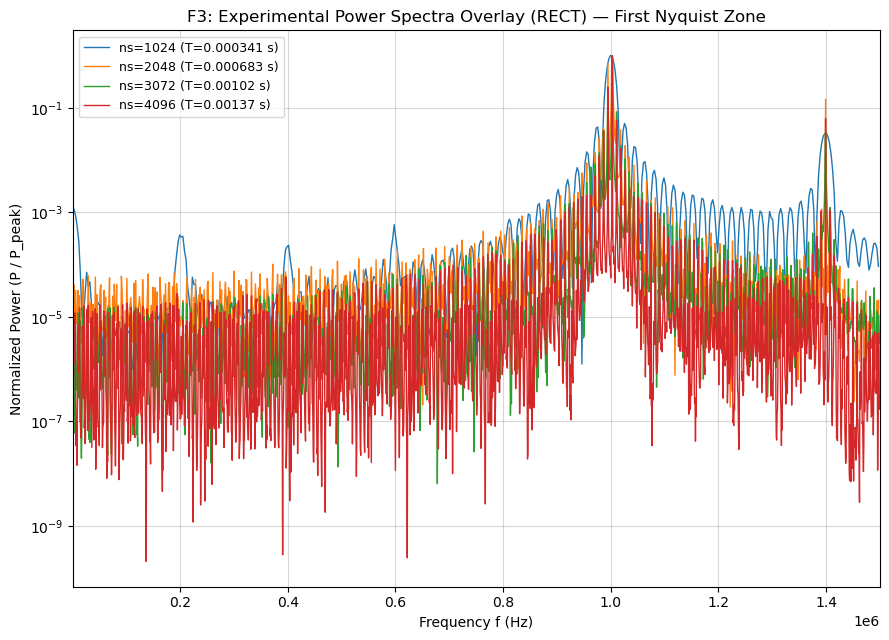

Saved: C:\Users\Storm\Astron 121\Data\F3_1MHz_5mV\data\F3_overlay_power_exp_all_rect_first_nyquist.png
Done.


In [10]:
# F3
# Plot ALL EXPERIMENTAL power spectra on ONE plot (overlay) — NO accepted/simulated.
# X-axis fixed to FIRST NYQUIST ZONE: 0 < f <= Fs/2 (log-x so we exclude 0).
# Saves directly in:
# C:\Users\Storm\Astron 121\Data\F3_1MHz_5mV\data

import os
import re
import numpy as np
import matplotlib.pyplot as plt
import wesleyanalysis

# -------------------
# Paths
# -------------------
DATA_DIR = r"C:\Users\Storm\Astron 121\Data\F3_1MHz_5mV\data"
PLOTS_DIR = DATA_DIR  # SAVE HERE

# -------------------
# User knobs
# -------------------
FS_HZ = 3e6

# selection:
#   "all"      = plot every .npy/.npz file found
#   "first4"   = first 4 files after sorting by ns
#   "largest4" = 4 largest ns
SELECT_MODE = "all"
N_TO_PLOT = 4  # only used for first4/largest4

# normalize each spectrum to its own peak (recommended for shape comparison)
NORMALIZE_TO_PEAK = True

# optional: ignore the first few Hz near DC when finding the peak (helps if DC leakage dominates)
IGNORE_DC_HZ = 0.0   # e.g. set 1000.0 to ignore |f| < 1 kHz

# -------------------
# Helpers
# -------------------
def load_capture(fp):
    obj = np.load(fp, allow_pickle=True)
    if isinstance(obj, np.lib.npyio.NpzFile):
        for k in ("the_data", "data", "x"):
            if k in obj.files:
                return obj[k]
        return obj[obj.files[0]]
    return obj

def parse_ns(fname):
    m = re.search(r"ns[_\-]?(\d+)", fname)
    return int(m.group(1)) if m else None

# -------------------
# Find data files
# -------------------
files = []
for fn in os.listdir(DATA_DIR):
    if fn.endswith(".npz") or fn.endswith(".npy"):
        ns = parse_ns(fn)
        files.append((ns, os.path.join(DATA_DIR, fn), fn))

files.sort(key=lambda x: (x[0] is None, x[0] if x[0] is not None else 0, x[2]))

if len(files) == 0:
    raise RuntimeError(f"No .npy/.npz files found in {DATA_DIR}")

# select files
if SELECT_MODE == "all":
    chosen = files
elif SELECT_MODE == "first4":
    chosen = files[:N_TO_PLOT]
elif SELECT_MODE == "largest4":
    with_ns = [x for x in files if x[0] is not None]
    with_ns.sort(key=lambda x: x[0])
    chosen = with_ns[-N_TO_PLOT:] if len(with_ns) >= N_TO_PLOT else with_ns
else:
    raise ValueError("SELECT_MODE must be 'all', 'first4', or 'largest4'")

print("Chosen files:")
for ns_guess, fp, fn in chosen:
    print("  ", fn)

# -------------------
# Build overlay plot
# -------------------
fig, ax = plt.subplots(figsize=(9, 6.5))

min_df = None  # track smallest 1/T for xlim lower bound

for ns_guess, fp, fn in chosen:
    data = load_capture(fp)

    # always use block 1 if it's a 2D array, else treat as 1D
    x = data[1] if isinstance(data, np.ndarray) and data.ndim == 2 else np.asarray(data)
    x = np.asarray(x, dtype=float)
    ns = len(x)
    T = ns / FS_HZ

    # track best lower bound for log-x (resolution ~ 1/T)
    df0 = 1.0 / T
    min_df = df0 if (min_df is None) else min(min_df, df0)

    # RECT preprocessing
    xw = x - np.mean(x)

    # power spectrum + frequency axis
    P = wesleyanalysis.power_spectrum(xw)
    f = np.fft.fftfreq(ns, d=1/FS_HZ)

    P = np.fft.fftshift(P)
    f = np.fft.fftshift(f)

    # FIRST NYQUIST ZONE (positive freqs only) — exclude 0 for log-x
    pos = (f > 0) & (f <= FS_HZ / 2.0)
    f_pos = f[pos]
    P_pos = P[pos]

    if f_pos.size < 10:
        print(f"Skipping {fn}: not enough positive-frequency points")
        continue

    # peak selection for normalization (optionally ignore DC-ish region)
    if IGNORE_DC_HZ > 0:
        m_pk = f_pos >= IGNORE_DC_HZ
        if np.any(m_pk):
            i_rel = int(np.argmax(P_pos[m_pk]))
            pk_inds = np.where(m_pk)[0]
            i_pk = int(pk_inds[i_rel])
        else:
            i_pk = int(np.argmax(P_pos))
    else:
        i_pk = int(np.argmax(P_pos))

    P_pk = float(P_pos[i_pk])

    if NORMALIZE_TO_PEAK:
        if P_pk <= 0 or not np.isfinite(P_pk):
            print(f"Skipping {fn}: non-positive/invalid peak power")
            continue
        P_plot = P_pos / P_pk
        ylab = "Normalized Power (P / P_peak)"
    else:
        P_plot = P_pos
        ylab = "Power"

    label = f"ns={ns} (T={T:.3g} s)"
    ax.plot(f_pos, P_plot, lw=1, label=label)

    print(f"{fn}: ns={ns}, T={T:.6g} s, peak f={f_pos[i_pk]:.3f} Hz")

# axis scales/labels
#ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Frequency f (Hz)")
ax.set_ylabel(ylab)
ax.set_title("F3: Experimental Power Spectra Overlay (RECT) — First Nyquist Zone")
ax.grid(True, which="both", alpha=0.5)
ax.legend(fontsize=9)
ax.set_xlim((FS_HZ/2)-(FS_HZ/4),FS_HZ/2)

# FIX x-axis to first Nyquist zone explicitly:
# lower bound must be >0 for log; use smallest 1/T among plotted runs (fallback 1 Hz)
xlo = (min_df if (min_df is not None and np.isfinite(min_df) and min_df > 0) else 1.0)
ax.set_xlim(xlo, FS_HZ / 2.0)

fig.tight_layout()

out_png = os.path.join(
    PLOTS_DIR,
    "F3_overlay_power_exp_all_rect_first_nyquist.png" if SELECT_MODE == "all"
    else "F3_overlay_power_exp_rect_first_nyquist.png"
)
fig.savefig(out_png, bbox_inches="tight")
#plt.close(fig)

plt.show()
print(f"Saved: {out_png}")
print("Done.")


In [183]:
# F3
# Plot ALL EXPERIMENTAL power spectra on ONE plot (overlay)
# X-axis: FULL NYQUIST RANGE -> -Fs/2 <= f <= +Fs/2   (Fs = 3 MHz)
# Linear x-axis (NOT log) so negative frequencies are allowed.
#
# Saves directly in:
# C:\Users\Storm\Astron 121\Data\F3_1MHz_5mV\data

import os
import re
import numpy as np
import matplotlib.pyplot as plt
import wesleyanalysis

# -------------------
# Paths
# -------------------
DATA_DIR = r"C:\Users\Storm\Astron 121\Data\F3_1MHz_5mV\data"
PLOTS_DIR = DATA_DIR

# -------------------
# User knobs
# -------------------
FS_HZ = 3e6                     # sampling frequency (Hz)
SELECT_MODE = "all"             # "all", "first4", "largest4"
N_TO_PLOT = 4                   # only used for first4/largest4
NORMALIZE_TO_PEAK = True        # normalize each spectrum to its own peak

# Optional: if DC spike dominates, you can ignore a small region around 0 in normalization
IGNORE_AROUND_DC_HZ = 0.0       # e.g. 500.0 to ignore |f| < 500 Hz when finding peak

# -------------------
# Helpers
# -------------------
def load_capture(fp):
    obj = np.load(fp, allow_pickle=True)
    if isinstance(obj, np.lib.npyio.NpzFile):
        for k in ("the_data", "data", "x"):
            if k in obj.files:
                return obj[k]
        return obj[obj.files[0]]
    return obj

def parse_ns(fname):
    m = re.search(r"ns[_\-]?(\d+)", fname)
    return int(m.group(1)) if m else None

# -------------------
# Find data files
# -------------------
files = []
for fn in os.listdir(DATA_DIR):
    if fn.endswith(".npy") or fn.endswith(".npz"):
        ns = parse_ns(fn)
        files.append((ns, os.path.join(DATA_DIR, fn), fn))

files.sort(key=lambda x: (x[0] is None, x[0] if x[0] is not None else 0, x[2]))

if len(files) == 0:
    raise RuntimeError(f"No .npy/.npz files found in {DATA_DIR}")

if SELECT_MODE == "all":
    chosen = files
elif SELECT_MODE == "first4":
    chosen = files[:N_TO_PLOT]
elif SELECT_MODE == "largest4":
    with_ns = [x for x in files if x[0] is not None]
    with_ns.sort(key=lambda x: x[0])
    chosen = with_ns[-N_TO_PLOT:] if len(with_ns) >= N_TO_PLOT else with_ns
else:
    raise ValueError("SELECT_MODE must be 'all', 'first4', or 'largest4'")

print("Chosen files:")
for _, _, fn in chosen:
    print("  ", fn)

# -------------------
# Build overlay plot
# -------------------
fig, ax = plt.subplots(figsize=(10, 6.5))

for ns_guess, fp, fn in chosen:
    data = load_capture(fp)

    # always use block 1 if 2D array, else treat as 1D
    x = data[1] if isinstance(data, np.ndarray) and data.ndim == 2 else np.asarray(data)
    x = np.asarray(x, dtype=float)

    ns = len(x)
    T = ns / FS_HZ

    # RECT preprocessing
    xw = x - np.mean(x)

    # power spectrum + frequency axis
    P = wesleyanalysis.power_spectrum(xw)
    f = np.fft.fftfreq(ns, d=1/FS_HZ)

    # shift so f runs from ~-Fs/2..+Fs/2
    P = np.fft.fftshift(P)
    f = np.fft.fftshift(f)

    # Normalize (optional)
    if NORMALIZE_TO_PEAK:
        if IGNORE_AROUND_DC_HZ > 0:
            m_pk = np.abs(f) >= IGNORE_AROUND_DC_HZ
            Ppk = np.max(P[m_pk]) if np.any(m_pk) else np.max(P)
        else:
            Ppk = np.max(P)

        if not np.isfinite(Ppk) or Ppk <= 0:
            print(f"Skipping {fn}: invalid peak power")
            continue

        P_plot = P / Ppk
        ylabel = "Normalized Power (P / P_peak)"
    else:
        P_plot = P
        ylabel = "Power"

    label = f"ns={ns} (T={T:.3g} s)"
    ax.plot(f, P_plot, lw=1.3, label=label)

    print(f"{fn}: ns={ns}, T={T:.6g} s")

# -------------------
# Axis formatting (FULL Nyquist range)
# -------------------
ax.set_xlim(-FS_HZ/2, FS_HZ/2)   # <-- EXACTLY -Fs/2 to +Fs/2
ax.set_xlabel("Frequency f (Hz)")
ax.set_ylabel(ylabel)
ax.set_title("F3: Experimental Power Spectra Overlay (RECT)\nFull Nyquist Range (−Fs/2 to +Fs/2), Fs = 3 MHz")
ax.grid(True, which="both", alpha=0.5)
ax.legend(fontsize=9)

fig.tight_layout()

out_png = os.path.join(PLOTS_DIR, "F3_overlay_power_exp_all_rect_full_nyquist_linearx.png")
fig.savefig(out_png, bbox_inches="tight")
plt.close(fig)

print(f"Saved: {out_png}")
print("Displayed x-range: [{-FS_HZ/2:.1f}, {FS_HZ/2:.1f}] Hz  (Fs/2 = {FS_HZ/2:.1f} Hz)")
print("Done.")


Chosen files:
   digital_sin_ns_1024.npz
   digital_sin_ns_2048.npz
   digital_sin_ns_3072.npz
   digital_sin_ns_4096.npz
   F3_peak_coords_ns_sweep_rect.npy
   peak_coords_ns_sweep_rect.npy
digital_sin_ns_1024.npz: ns=1024, T=0.000341333 s
digital_sin_ns_2048.npz: ns=2048, T=0.000682667 s
digital_sin_ns_3072.npz: ns=3072, T=0.001024 s
digital_sin_ns_4096.npz: ns=4096, T=0.00136533 s
F3_peak_coords_ns_sweep_rect.npy: ns=5, T=1.66667e-06 s
peak_coords_ns_sweep_rect.npy: ns=5, T=1.66667e-06 s
Saved: C:\Users\Storm\Astron 121\Data\F3_1MHz_5mV\data\F3_overlay_power_exp_all_rect_full_nyquist_linearx.png
Displayed x-range: [{-FS_HZ/2:.1f}, {FS_HZ/2:.1f}] Hz  (Fs/2 = {FS_HZ/2:.1f} Hz)
Done.
